<div style='background-color:orange'>
<a id='TableOfContents'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Table of Contents
    </h1></i></u></b>
    <li><a href='#imports'>Imports</a>
    <li><a href='#initial'>Initial Setup</a>
    <li><a href='#model'>Modeling</a>
    <li><a href='#bestmodel'>Best Model(s)</a>
    <li><a href='#misc'>Miscellaneous</a>
    </li>
</div>

<div style='background-color:orange'>
<a id='imports'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Imports
    </h1></i></u></b>
    <li><a href='#TableOfContents'>Table of Contents</a>
    </li>
</div>

In [15]:
# Vectorization & Dataframe
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Encoder
from sklearn.preprocessing import OrdinalEncoder

# Model metric evaluation
from sklearn.metrics import accuracy_score

# .py files
import wrangle as w

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<div style='background-color:orange'>
<a id='initial'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Initial Setup
    </h1></i></u></b>
    <li><a href='#TableOfContents'>Table of Contents</a>
    </li>
</div>

In [16]:
# Load up master dataset
master = w.wrangle()
master.shape

(14174, 132)

In [58]:
master['population_group'].value_counts()

population_group
RURAL                    5414
250,000 POP AND OVER     3822
100,000 - 249,999 POP    1588
50,000 - 99,999 POP       844
10,000 - 24,999 POP       796
25,000 - 49,999 POP       776
5,000 - 9,999 POP         398
TOWN UNDER 2,499 POP      341
2,500 - 4,999 POP         195
Name: count, dtype: int64

In [18]:
# Feature selection for modeling (Predictive only)
all_cols = [
    'adjusted_average_daily_traffic_amount',
    'average_daily_traffic_amount',
    'average_daily_traffic_year',
    'city',
    'county',
    'population_group',
    'private_drive_flag',
    'road_base_type',
    'road_class',
    'roadbed_width',
    'roadway_alignment',
    'roadway_function',
    'roadway_part',
    'roadway_relation',
    'roadway_type',
    'rural_flag',
    'rural_urban_type',
    'surface_condition',
    'surface_width',
    'weather_condition',
    'driver_license_class',
    'driver_license_endorsements',
    'driver_license_restrictions',
    'driver_license_state',
    'driver_license_type',
    'license_plate_state',
    'possible_vehicle_defect_1',
    'vehicle_body_style',
    'vehicle_color',
    'vehicle_defect_1',
    'vehicle_make',
    'vehicle_model_name',
    'vehicle_model_year',
    'person_age',
    'person_ethnicity',
    'person_gender',
    'person_helmet',
    'person_type'
]

In [19]:
# Add the risk_agg column
risk_list, risk_dict = w.risk_scores_iterate_columns(master, all_cols)
master['agg_injury_risk'] = risk_list

In [20]:
# Append the new column to the feature selection list
all_cols.append('agg_injury_risk')

In [21]:
# THIS IS OPTIONAL!!!
# It appears that this column alone performs better
all_cols = ['agg_injury_risk']

In [23]:
# Encode feature selected columns
encoder = OrdinalEncoder()
for col in all_cols:
    if master[col].dtype == 'object':
        encoded_col = encoder.fit_transform(master[[col]])
        master[col] = encoded_col

In [24]:
# Split the data
train, validate, test = w.split(master, stratify='person_injury_severity')
train.shape, validate.shape, test.shape

((9924, 133), (2832, 133), (1418, 133))

In [32]:
# Create x/y for each split dataset
train_x = train[all_cols]
train_y = train.person_injury_severity
validate_x = validate[all_cols]
validate_y = validate.person_injury_severity
test_x = test[all_cols]
test_y = test.person_injury_severity

<div style='background-color:orange'>
<a id='model'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Models
    </h1></i></u></b>
    <li><a href='#TableOfContents'>Table of Contents</a>
    <li><a href='#modelcreatedict'>Create Model Dictionary</a>
    <li><a href='#modelbaseline'>Baseline</a>
    <li><a href='#modeldtc'>DecisionTreeClassifier</a>
    <li><a href='#modelrfc'>RandomForestClassifier</a>
    <li><a href='#modelknn'>K-Nearest Neighbors</a>
    <li><a href='#modellr'>Logistic Regression</a>
    </li>
</div>

<a id='modelcreatedict'></a>
<h3><b><i>
    Create Model Dictionary
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [33]:
# Create base look of models_dict
models_dict = {
    'model_name' : [],
    'model_type' : [],
    'model_params' : [],
    'train_accuracy' : [],
    'validate_accuracy' : [],
    'accuracy_diff' : []
}

---

<a id='modelbaseline'></a>
<h3><b><i>
    Baseline
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [34]:
# Establish the ratio of the most common value
mode_value = train.person_injury_severity.mode()[0]
mode_total_train = (train.person_injury_severity == mode_value).sum()
mode_total_validate = (validate.person_injury_severity == mode_value).sum()
mode_total_test = (test.person_injury_severity == mode_value).sum()
mode_percent_train = mode_total_train / train.shape[0]
mode_percent_validate = mode_total_validate / validate.shape[0]
mode_percent_test = mode_total_test / test.shape[0]

In [35]:
# Append baseline to 'models_dict'
models_dict['model_name'].append('baseline')
models_dict['model_type'].append('baseline - mode')
models_dict['model_params'].append('none')
models_dict['train_accuracy'].append(f'{mode_percent_train:.3f}')
models_dict['validate_accuracy'].append(f'{mode_percent_validate:.3f}')
models_dict['accuracy_diff'].append(f'{mode_percent_validate - mode_percent_train:.3f}')

In [36]:
# Check out the 'models_dict'
pd.DataFrame(models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,accuracy_diff
0,baseline,baseline - mode,none,0.575,0.575,0.000


---

<a id='modeldtc'></a>
<h3><b><i>
    DecisionTreeClassifier
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [37]:
# Create generic DecisionTreeClassifer
for i in range(1, 11):
    model_name = f'dtc{i}'
    dtc = DecisionTreeClassifier(max_depth=i, random_state=1776)
    dtc.fit(train_x, train_y)
    train_score = dtc.score(train_x, train_y)
    val_score = dtc.score(validate_x, validate_y)
    diff_score = val_score - train_score
    models_dict['model_name'].append(model_name)
    models_dict['model_type'].append('Decision Tree Classifier')
    models_dict['model_params'].append(f'max_depth={i}, random_state=1776')
    models_dict['train_accuracy'].append(f'{train_score:.3f}')
    models_dict['validate_accuracy'].append(f'{val_score:.3f}')
    models_dict['accuracy_diff'].append(f'{diff_score:.3f}')

In [38]:
# Check out the 'models_dict'
pd.DataFrame(models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,accuracy_diff
0,baseline,baseline - mode,none,0.575,0.575,0.000
1,dtc1,Decision Tree Classifier,"max_depth=1, random_state=1776",0.662,0.664,0.002
2,dtc2,Decision Tree Classifier,"max_depth=2, random_state=1776",0.677,0.676,-0.001
3,dtc3,Decision Tree Classifier,"max_depth=3, random_state=1776",0.677,0.676,-0.001
4,dtc4,Decision Tree Classifier,"max_depth=4, random_state=1776",0.679,0.675,-0.003
5,dtc5,Decision Tree Classifier,"max_depth=5, random_state=1776",0.679,0.675,-0.005
6,dtc6,Decision Tree Classifier,"max_depth=6, random_state=1776",0.681,0.671,-0.011
7,dtc7,Decision Tree Classifier,"max_depth=7, random_state=1776",0.685,0.665,-0.019
8,dtc8,Decision Tree Classifier,"max_depth=8, random_state=1776",0.688,0.663,-0.025
9,dtc9,Decision Tree Classifier,"max_depth=9, random_state=1776",0.694,0.662,-0.032


---

<a id='modelrfc'></a>
<h3><b><i>
    RandomForestClassifier
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [39]:
# Create generic RandomForestClassifer
for i in range(1, 11):
    model_name = f'rfc{i}'
    rfc = RandomForestClassifier(max_depth=i, random_state=1776)
    rfc.fit(train_x, train_y)
    train_score = rfc.score(train_x, train_y)
    val_score = rfc.score(validate_x, validate_y)
    diff_score = val_score - train_score
    models_dict['model_name'].append(model_name)
    models_dict['model_type'].append('Random Forest Classifier')
    models_dict['model_params'].append(f'max_depth={i}, random_state=1776')
    models_dict['train_accuracy'].append(f'{train_score:.3f}')
    models_dict['validate_accuracy'].append(f'{val_score:.3f}')
    models_dict['accuracy_diff'].append(f'{diff_score:.3f}')

In [40]:
# Check out the 'models_dict'
pd.DataFrame(models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,accuracy_diff
0,baseline,baseline - mode,none,0.575,0.575,0.000
1,dtc1,Decision Tree Classifier,"max_depth=1, random_state=1776",0.662,0.664,0.002
2,dtc2,Decision Tree Classifier,"max_depth=2, random_state=1776",0.677,0.676,-0.001
3,dtc3,Decision Tree Classifier,"max_depth=3, random_state=1776",0.677,0.676,-0.001
4,dtc4,Decision Tree Classifier,"max_depth=4, random_state=1776",0.679,0.675,-0.003
5,dtc5,Decision Tree Classifier,"max_depth=5, random_state=1776",0.679,0.675,-0.005
6,dtc6,Decision Tree Classifier,"max_depth=6, random_state=1776",0.681,0.671,-0.011
7,dtc7,Decision Tree Classifier,"max_depth=7, random_state=1776",0.685,0.665,-0.019
8,dtc8,Decision Tree Classifier,"max_depth=8, random_state=1776",0.688,0.663,-0.025
9,dtc9,Decision Tree Classifier,"max_depth=9, random_state=1776",0.694,0.662,-0.032


---

<a id='modelknn'></a>
<h3><b><i>
    K-Nearest Neighbors
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [41]:
# Create generic K-Nearest Neighbors
for i in range(11, 21):
    model_name = f'knn{i}'
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x, train_y)
    train_score = knn.score(train_x, train_y)
    val_score = knn.score(validate_x, validate_y)
    diff_score = val_score - train_score
    models_dict['model_name'].append(model_name)
    models_dict['model_type'].append('K-Nearest Neighbors')
    models_dict['model_params'].append(f'n_neighbors={i}')
    models_dict['train_accuracy'].append(f'{train_score:.3f}')
    models_dict['validate_accuracy'].append(f'{val_score:.3f}')
    models_dict['accuracy_diff'].append(f'{diff_score:.3f}')

In [42]:
# Check out the 'models_dict'
pd.DataFrame(models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,accuracy_diff
0,baseline,baseline - mode,none,0.575,0.575,0.000
1,dtc1,Decision Tree Classifier,"max_depth=1, random_state=1776",0.662,0.664,0.002
2,dtc2,Decision Tree Classifier,"max_depth=2, random_state=1776",0.677,0.676,-0.001
3,dtc3,Decision Tree Classifier,"max_depth=3, random_state=1776",0.677,0.676,-0.001
4,dtc4,Decision Tree Classifier,"max_depth=4, random_state=1776",0.679,0.675,-0.003
5,dtc5,Decision Tree Classifier,"max_depth=5, random_state=1776",0.679,0.675,-0.005
6,dtc6,Decision Tree Classifier,"max_depth=6, random_state=1776",0.681,0.671,-0.011
7,dtc7,Decision Tree Classifier,"max_depth=7, random_state=1776",0.685,0.665,-0.019
8,dtc8,Decision Tree Classifier,"max_depth=8, random_state=1776",0.688,0.663,-0.025
9,dtc9,Decision Tree Classifier,"max_depth=9, random_state=1776",0.694,0.662,-0.032


---

<a id='modellr'></a>
<h3><b><i>
    Logistic Regression
</i></b></h3>
<li><a href='#model'>Models Top</a></li>

In [43]:
# Create generic Logistic Regression
for i in range(1, 11):
    model_name = f'lr{i}'
    lr = LogisticRegression(solver='liblinear', intercept_scaling=i)
    lr.fit(train_x, train_y)
    train_score = lr.score(train_x, train_y)
    val_score = lr.score(validate_x, validate_y)
    diff_score = val_score - train_score
    models_dict['model_name'].append(model_name)
    models_dict['model_type'].append('Logistic Regression')
    models_dict['model_params'].append(f'solver=\'liblinear\', intercept_scaling{i}')
    models_dict['train_accuracy'].append(f'{train_score:.3f}')
    models_dict['validate_accuracy'].append(f'{val_score:.3f}')
    models_dict['accuracy_diff'].append(f'{diff_score:.3f}')

In [44]:
# Check out the 'models_dict'
pd.DataFrame(models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,accuracy_diff
0,baseline,baseline - mode,none,0.575,0.575,0.000
1,dtc1,Decision Tree Classifier,"max_depth=1, random_state=1776",0.662,0.664,0.002
2,dtc2,Decision Tree Classifier,"max_depth=2, random_state=1776",0.677,0.676,-0.001
3,dtc3,Decision Tree Classifier,"max_depth=3, random_state=1776",0.677,0.676,-0.001
4,dtc4,Decision Tree Classifier,"max_depth=4, random_state=1776",0.679,0.675,-0.003
5,dtc5,Decision Tree Classifier,"max_depth=5, random_state=1776",0.679,0.675,-0.005
6,dtc6,Decision Tree Classifier,"max_depth=6, random_state=1776",0.681,0.671,-0.011
7,dtc7,Decision Tree Classifier,"max_depth=7, random_state=1776",0.685,0.665,-0.019
8,dtc8,Decision Tree Classifier,"max_depth=8, random_state=1776",0.688,0.663,-0.025
9,dtc9,Decision Tree Classifier,"max_depth=9, random_state=1776",0.694,0.662,-0.032


dtc2 appears to perform the best

<div style='background-color:orange'>
<a id='bestmodel'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Best Model(s)
    </h1></i></u></b>
    <li><a href='#TableOfContents'>Table of Contents</a>
    </li>
</div>

In [45]:
# Create best_models_dict
best_models_dict = {
    'model_name' : ['baseline'],
    'model_type' : ['baseline - mode'],
    'model_params' : ['none'],
    'train_accuracy' : [f'{mode_percent_train:.3f}'],
    'validate_accuracy' : [f'{mode_percent_validate:.3f}'],
    'test_accuracy' : [f'{mode_percent_test:.3f}']
}

In [46]:
# Recreate rfc5 and test it
dtc = DecisionTreeClassifier(max_depth=2, random_state=1776)
dtc.fit(train_x, train_y)
train_score = dtc.score(train_x, train_y)
val_score = dtc.score(validate_x, validate_y)
test_score = dtc.score(test_x, test_y)
best_models_dict['model_name'].append('dtc2')
best_models_dict['model_type'].append('Decision Tree Classifier')
best_models_dict['model_params'].append(f'max_depth=2, random_state=1776')
best_models_dict['train_accuracy'].append(f'{train_score:.3f}')
best_models_dict['validate_accuracy'].append(f'{val_score:.3f}')
best_models_dict['test_accuracy'].append(f'{test_score:.3f}')

In [47]:
# Check out the 'models_dict'
pd.DataFrame(best_models_dict)

,model_name,model_type,model_params,train_accuracy,validate_accuracy,test_accuracy
0,baseline,baseline - mode,none,0.575,0.575,0.575
1,dtc2,Decision Tree Classifier,"max_depth=2, random_state=1776",0.677,0.676,0.652


<div style='background-color:orange'>
<a id='misc'></a>
    <b><u><i><h1 style='text-align:center ; padding-top:5px'>
        Miscellaneous
    </h1></i></u></b>
    <li><a href='#TableOfContents'>Table of Contents</a>
    </li>
</div>

In [50]:
models_df = {'Model': {0: 'Baseline',
                           1: 'Decision Tree',
                           2: 'Random Forest',
                           3: 'KNN',
                           4: 'Logistic Regression'},
                'Best Estimator': {0: 'Baseline-Mode',
                                   1: 'DecisionTreeClassifier(max_depth=3, random_state=1776)',
                                   2: 'RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=1776)',
                                   3: 'KNeighborsClassifier(algorithm=\'ball_tree\', n_neighbors=50)',
                                   4: 'LogisticRegression(C=10, random_state=1776, solver=\'sag\')'},
                'Best Parameters': {0: 'Baseline-Mode',
                                    1: {'max_depth': 3,
                                        'min_samples_leaf': 1,
                                        'min_samples_split': 2,
                                        'random_state': 1776},
                                    2: {'max_depth': 5,
                                        'min_samples_leaf': 2,
                                        'min_samples_split': 2,
                                        'n_estimators': 100,
                                        'random_state': 1776},
                                    3: {'algorithm': 'ball_tree', 
                                        'n_neighbors': 50, 
                                        'weights': 'uniform'},
                                    4: {'C': 10, 
                                        'random_state': 1776, 
                                        'solver': 'sag'}},
                'Train Accuracy': {0: 0.575,
                                   1: 0.6763399386527992,
                                   2: 0.6764406943203054,
                                   3: 0.6694878422848787,
                                   4: 0.6563882851222881},
                'Validate Accuracy': {0: 0.575,
                                      1: 0.6762005649717514,
                                      2: 0.6758474576271186,
                                      3: 0.6716101694915254,
                                      4: 0.6581920903954802}}

In [ ]:
dtc = DecisionTreeClassifier(max_depth=i, random_state=1776)
dtc.fit(train_x, train_y)
train_score = dtc.score(train_x, train_y)
val_score = dtc.score(validate_x, validate_y)
diff_score = val_score - train_score
models_dict['model_name'].append(model_name)
models_dict['model_type'].append('Decision Tree Classifier')
models_dict['model_params'].append(f'max_depth={i}, random_state=1776')
models_dict['train_accuracy'].append(f'{train_score:.3f}')
models_dict['validate_accuracy'].append(f'{val_score:.3f}')
models_dict['accuracy_diff'].append(f'{diff_score:.3f}')

In [61]:
thingy = pd.DataFrame(models_df)
thingy['Best Parameters'][1]

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 1776}

In [54]:
# Find the best hyperparameter for the agg_risk
#gridsearch_dict = w.gridsearchcv_hyperparameter_tuning(train, validate, all_cols, 'person_injury_severity')
gridsearch_dict

,Model,Best Estimator,Best Parameters,Train Accuracy,Validate Accuracy
0,Decision Tree,"DecisionTreeClassifier(max_depth=3, random_sta...","{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.676340,0.676201
1,Random Forest,"(DecisionTreeClassifier(max_depth=5, max_featu...","{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.676441,0.675847
2,KNN,"KNeighborsClassifier(algorithm='ball_tree', n_...","{'algorithm': 'ball_tree', 'n_neighbors': 50, ...",0.669488,0.671610
3,Logistic Regression,"LogisticRegression(C=10, random_state=1776, so...","{'C': 10, 'random_state': 1776, 'solver': 'sag'}",0.656388,0.658192


<Axes: xlabel='agg_injury_risk', ylabel='person_injury_severity'>

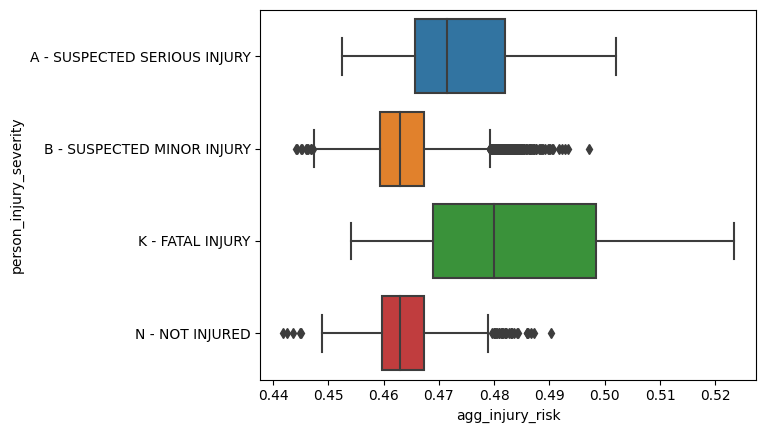

In [57]:
sns.boxplot(data=train, x='agg_injury_risk', y='person_injury_severity')